In [9]:
from utils.task import get_input
from utils.analysis import get_attractors, plot_hiddens_and_data, get_speed, get_unique_fixed_points, visualize_fixed_points, is_stable, get_all_hiddens
from utils.model import plot_behavior
from utils.utils import get_model, get_fixed_points

import torch

In [2]:
def interpolate_input(task_idx, period, stimulus, tasks, n_interp, step_i):
    input1 = get_input(task_idx[0], period[0], stimulus[0], tasks)
    input2 = get_input(task_idx[1], period[1], stimulus[1], tasks)

    interpolated_input = (n_interp - step_i)/n_interp * input1 + (step_i/n_interp) * input2
    return interpolated_input

In [14]:
# Select a model

model_name = "delaygo_delayanti_64"
rnn, tasks = get_model(model_name)

## Network behavior

Plot the behavior of the model on all input sequences for all tasks. Use larger period durations to test if the computation is time-independent.

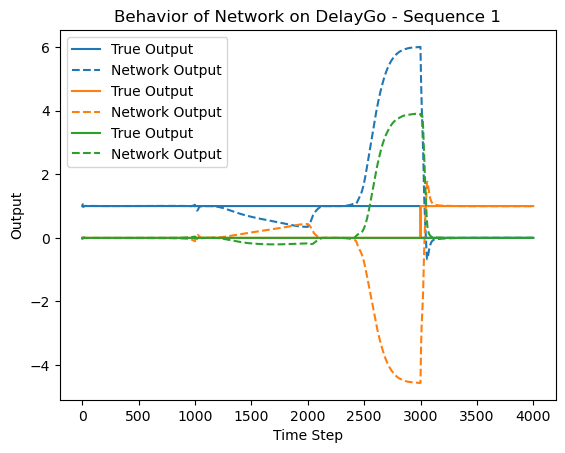

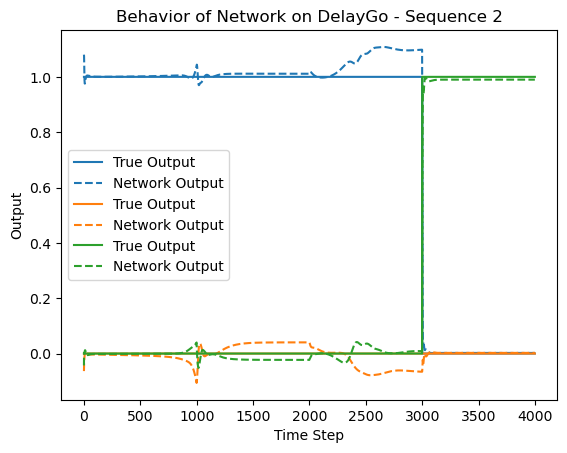

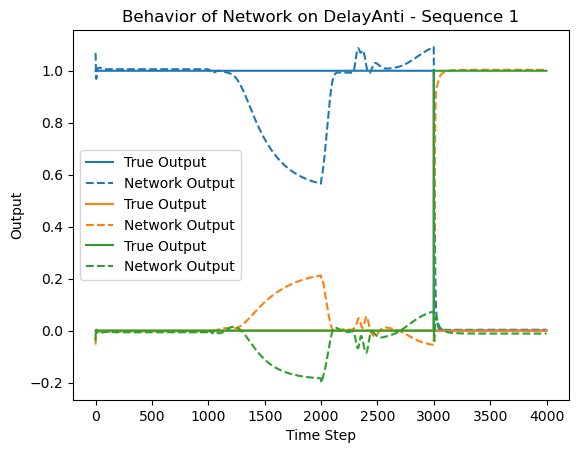

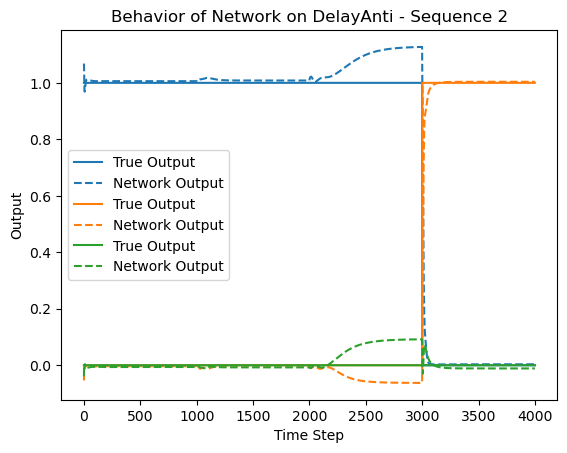

In [15]:
period_duration=1000
plot_behavior(rnn, tasks, period_duration=period_duration)

## Fixed points for a single input

In [5]:
# Set the input

interpolate = False    # Variable for interpolated vs. direct input

if interpolate:
  # Paramters for interpolated input
  task_idx = [0,1]
  period = ["delay", "delay"]
  stimulus = [1, 1]
  n_interp = 20
  step_i = 3

  input = interpolate_input(task_idx, period, stimulus, tasks, n_interp, step_i)

else:
  # Parameters for input computed directly from task
  task_idx = 0
  period = "delay"
  stimulus = 1
  input = get_input(task_idx, period, stimulus, tasks)

print(f"The input is {input.numpy()}.")

The input is [1. 0. 0. 1. 0.].


In [6]:
# Get the fixed points for that input

fps = get_fixed_points(model_name, input)

unique_fps = get_unique_fixed_points(fps.detach()).detach()
print(f"There are {len(unique_fps)} unique fixed points.")

There are 3 unique fixed points.


In [7]:
speeds = get_speed(rnn, input, unique_fps.float())
for i, fp in enumerate(unique_fps):
    if is_stable(rnn, fp, input):
        stability = "stable"
    else:
        stability = "unstable"

    print(f"Fixed point {i} has speed {speeds[i]} and is {stability}")

Fixed point 0 has speed 1.257769555174093e-09 and is unstable
Fixed point 1 has speed 5.764351218573438e-09 and is stable
Fixed point 2 has speed 1.6214915632417615e-08 and is stable


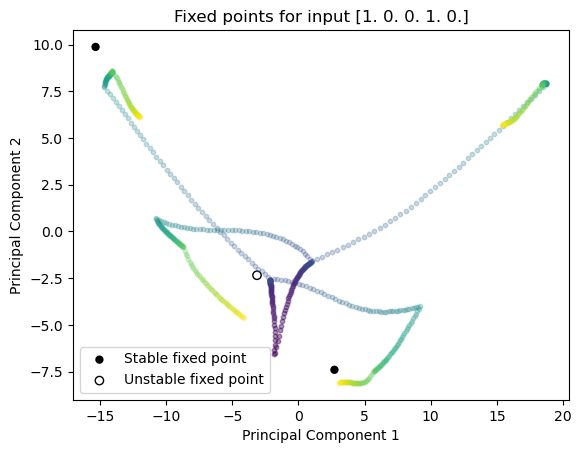

In [8]:
# Plot the fixed points

stable_fps = []
unstable_fps = []

for fixed_point in unique_fps:
    if is_stable(rnn, fixed_point, input):
        stable_fps.append(fixed_point)
    else:
        unstable_fps.append(fixed_point)

plot_hiddens_and_data(rnn, tasks, 
                             [torch.stack(stable_fps), torch.stack(unstable_fps)], 
                             label_list = ['Stable fixed point', 'Unstable fixed point'],
                             filled_list = [True, False],
                             title = f"Fixed points for input {input.numpy()}")

## Fixed points for interpolated inputs

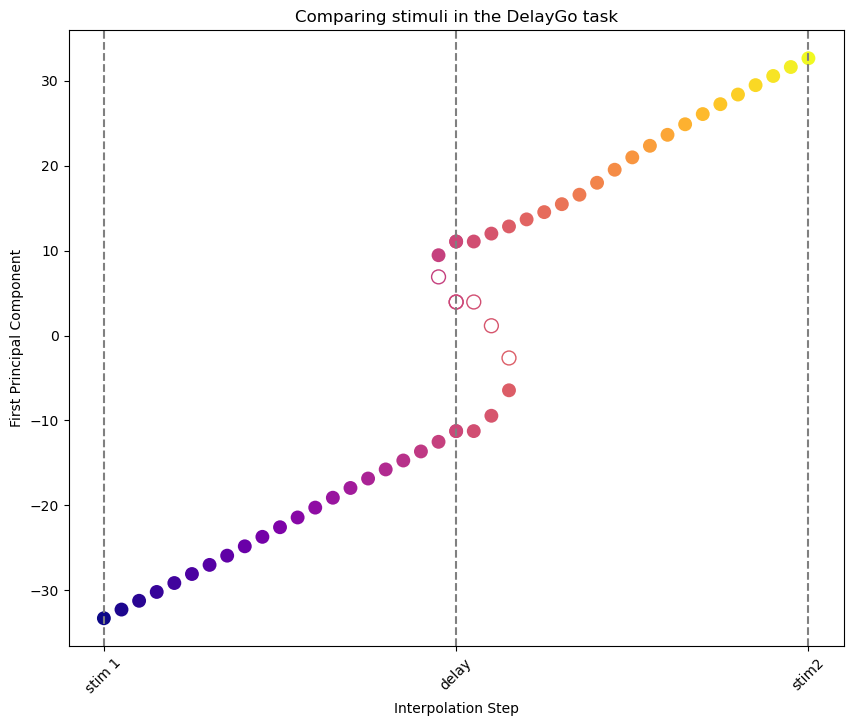

In [19]:
task_idx = [0,0,0]
period = ["stim", "delay", "stim"]
stimulus = [1,1,2]
n_interp = 20
labels = ["stim 1" , "delay", "stim2"]
title = "Comparing stimuli in the DelayGo task"

visualize_fixed_points(model_name, task_idx, period, stimulus, n_interp, input_labels = labels, title = title)

## Attractors for a single input

It is also sometimes useful to find the attractors for a single input by running the network forwards and visualizing the points to which it converges. Unlike fixed point finder, this method can find attractors with more complex topologies. However, this method cannot be used to find unstable invariant sets. 

In [13]:
# Set the input

interpolate = False    # Variable for interpolated vs. direct input

if interpolate:
  # Paramters for interpolated input
  task_idx = [0,1]
  period = ["delay", "delay"]
  stimulus = [1, 1]
  n_interp = 20
  step_i = 3

  input = interpolate_input(task_idx, period, stimulus, tasks, n_interp, step_i)

else:
  # Parameters for input computed directly from task
  task_idx = 0
  period = "delay"
  stimulus = 1
  input = get_input(task_idx, period, stimulus, tasks)

print(f"The input is {input.numpy()}.")

The input is [1. 0. 0. 1. 0.].


In [10]:
all_hiddens = get_all_hiddens(rnn, tasks)
num_timesteps = 3000
num_last = 100

attractors = get_attractors(rnn, input, all_hiddens, num_timesteps, num_last)

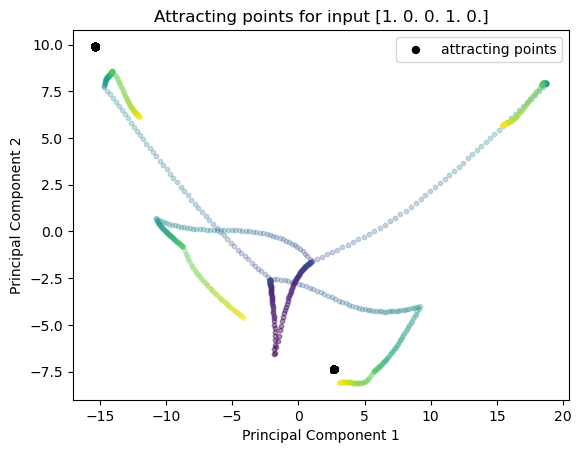

In [12]:
attractors = attractors.reshape(-1, attractors.shape[-1])
plot_hiddens_and_data(rnn, tasks, [attractors], 
                      label_list = ["attracting points"], 
                      title = f"Attracting points for input {input.numpy()}"
)